## FaceSegLite: Model Building

### **Imports**

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cpu


### **Dataset Loading**


First, we define utils function to be able to load the HuggingFace datasets correctly.

In [108]:
def load_yolo_format(file_path):
  """
  Loads a file in YOLO format.
  
  Args:
    - file_path: path to the file to load.
    
  Returns:
    - objects: np array of objects in the image. Each object is represented as a
      tuple of (x1, y1, ..., xn, yn).
  """
  with open(file_path, 'r') as f:
    lines = f.readlines()

  objects = []
  for line in lines:
    data = line.strip().split()
    class_index = int(data[0]) # We don't care about the class name because we work only with one class (face)
    coordinates = list(map(float, data[1:]))
    objects.append(coordinates)

  return objects

def found_directory(file_path, folders):
    """
    Finds the directory in which the file is located.

    Args:
        - file_path: path to the file to load.
        - folders: list of folders to look into.
    
    Returns:
        - folder: name of the folder in which the file is located.
    """
    for i, folder in enumerate(folders):
        file_id = file_path.split('_')[0]
        folder_id = folder.split('--')[0]
        if file_id == folder_id:
            return folders[i]
    raise ValueError(f"Folder {folders} not found in {file_path}")

Define a custom torch Dataset.

In [109]:
class FslDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.mask_folder = os.path.join(root_dir, 'masks')
        self.mask_files = sorted(os.listdir(self.mask_folder))

        self.image_folder = os.path.join(root_dir, 'images')
        self.image_files = [os.path.join(self.image_folder, found_directory(file_path, os.listdir(self.image_folder)),
                file_path.replace('txt', 'jpg')) for file_path in self.mask_files]

    def __len__(self):
        return len(self.mask_files)


    def __getitem__(self, idx):
        # Get the image
        image = cv2.imread(self.image_files[idx])

        # Get the masks
        masks = load_yolo_format(os.path.join(self.mask_folder, self.mask_files[idx]))

        sample = {'image': image, 'masks': masks}

        if self.transform:
            sample = self.transform(sample)
        
        return sample


Visualize some sample from our dataset.

In [125]:
def get_unique_color(index):
    """
    Generates a unique RGB color for a given class index.

    Args:
        - index: class index
    
    Returns:
        - color: tuple of (R, G, B) values
    """
    np.random.seed(index) # For reproducibility
    return tuple(np.random.rand(3))

def plot_image_with_mask(image, masks, title=None):
    """
    Plots an image with its segmentation mask.

    Args:
        - image (np array): image to plot.
        - masks: list of masks in the image. Each object is represented as (x1, y1, ..., xn, yn).
    """
    # Read the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image)

    # Plot the segmentation mask for each object with a unique color
    for index, coordinates in enumerate(masks):
        num_points = len(coordinates) // 2
        mask_points = np.array(coordinates).reshape((num_points, 2))
        mask_points *= np.array([image.shape[1], image.shape[0]])  # Convert normalized coordinates to pixels
        mask_points = mask_points.astype(int)

        # Draw a polygon for the segmentation mask
        color = get_unique_color(index)
        polygon = Polygon(mask_points, closed=True, edgecolor=color, facecolor='none', linewidth=2)
        plt.gca().add_patch(polygon)

        # Fill the polygon with a unique color
        plt.fill(mask_points[:, 0], mask_points[:, 1], color=color, alpha=0.3)

    # Show the plot
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

Sample 0


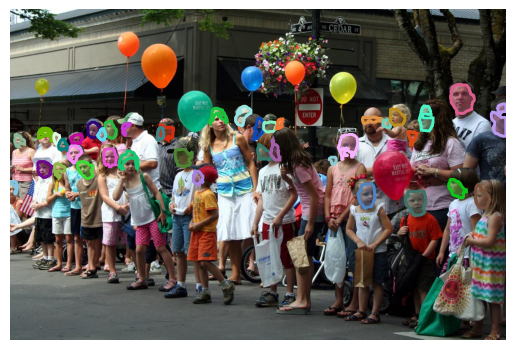

Sample 1


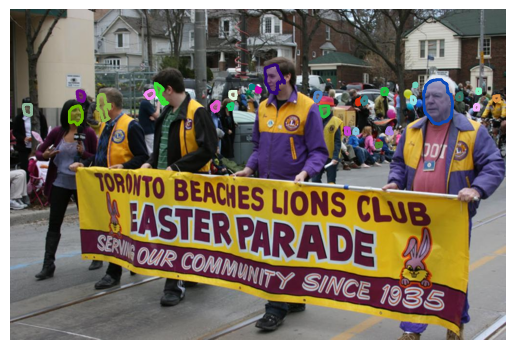

Sample 2


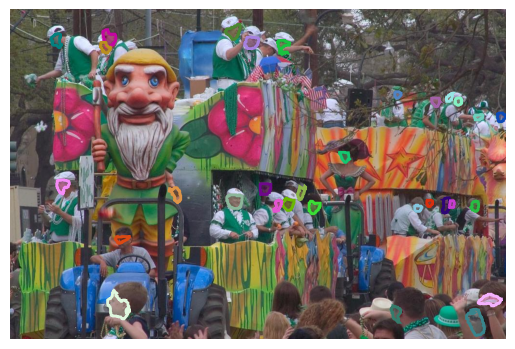

In [126]:
fsl_dataset = FslDataset(root_dir='../data/')

for i, sample in enumerate(fsl_dataset):
    if i == 3:
        break
    print(f"Sample {i}")
    plot_image_with_mask(sample['image'], sample['masks'])

### **Dataset Transformation**

TODO: Here we define the transformation for our dataset to be able to work efficiently for building our model

In [110]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, masks = sample['image'], sample['masks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'masks': torch.FloatTensor(masks)}

In [111]:
# TODO
#data_transform = transforms.Compose([
#    ToTensor(),
#    transforms.Resize((224, 224))
#])
#
#fsl_dataset = FslDataset(root_dir='../data/', transform=data_transform)
#fsl_dataset_loader = DataLoader(fsl_dataset, batch_size=4, shuffle=True, num_workers=4)

In [120]:
# TODO
#for i_batch, sample_batch in enumerate(fsl_dataset_loader):
#
#    print(f"i_batch = {i_batch}")
#    print(f"sample_batch['image'].shape = {sample_batch['image'].shape}")
#    print(f"sample_batch['masks'] = {sample_batch['masks']}")
#
#    if i_batch == 2:
#        break